In [2]:
import pandas as pd
from tdmsdata import TdmsData
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import erf
from scipy.special import erfc
from scipy.optimize import curve_fit   
from scipy.signal import fftconvolve
from scipy.stats import exponnorm
import statsmodels.api as sm
import os
import importlib
import doppler_shift_2024
import satlas2 as st

In [3]:
def read_tdms(folder_path, file, channel):
    TDMS = TdmsData(''.join([folder_path, file]))
    raw_data = TDMS.get_raw_data(''.join(['Channel ', str(channel)]))  # 2D np array, channel 1 = RAES, channel 3 = ID gated signal, channel 4 = ID gated bkg, channel 5 = nongated
    return raw_data

In [4]:
def create_df(raw_data):
    return pd.DataFrame({'Cycle No.': raw_data[:, 0], 'Time (sec)': raw_data[:, 1], 
                         'Laser Frequency (THz)': raw_data[:, 2], 'Approx Time': raw_data[:, 3], # Approx time is a timestamp for calib and interferometer 
                         'SDUMP': raw_data[:, 4], 'LE Probe': raw_data[:, 5]}) # SDUMP is dump current of PREVIOUS cycle (nA) and LE probe is beam energy (V) 

In [5]:
def doppler_shift_calc(dataset, isotope):
    importlib.reload(doppler_shift_2024)
    doppler_df = dataset.copy()
    freq = doppler_df['Laser Frequency (THz)']
    measured_voltage = doppler_df['LE Probe']
    shifted_freq = doppler_shift_2024.getshift(freq, isotope, measured_voltage)
    doppler_df['Laser Frequency (THz)'] = shifted_freq

    return doppler_df

In [6]:
def process_data(df):
    freq = 'Laser Frequency (THz)'
    bin_width = 50
    freq_range = (df[freq].max() - df[freq].min()) * 1e6 # MHz
    bins = int(np.ceil(freq_range / bin_width)) # number of bins will change to ensure bin worth is consistent 

    binned_df = (
            df
            .assign(Freq_bin=lambda df: pd.cut(df[freq], bins))
            .groupby('Freq_bin', observed=True) # separate counts for each bin and cycle
            .size()
            .reset_index(name='Count raw')
            .assign(Bin_center=lambda df: df['Freq_bin'].apply(lambda x: x.mid))
        )
    
    binned_df.columns = ['Freq bin', 'Count raw', 'Bin center']

    binned_df['Freq bin'] = binned_df['Freq bin'].astype('category')  # Match global dtype
    binned_df['Bin center'] = binned_df['Bin center'].astype(float)

    return binned_df

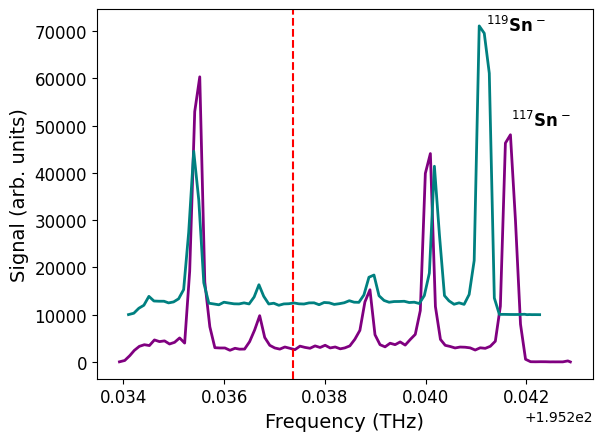

In [ ]:
folder_path = '/Users/xnimir/Desktop/Sn exp 2024/data/odds/'
file = '20241022_2251_Sn_119_.48to.535_0.0003nms.tdms'
file2 = '20241023_2221_Sn-117_.485to.540_0.0003nms.tdms'
channel = 1

raw_data_119 = read_tdms(folder_path, file, channel)
data_df_119 = create_df(raw_data_119)
doppler_df_119 = doppler_shift_calc(data_df_119, 119)
binned_df_119 = process_data(doppler_df_119)

raw_data_117 = read_tdms(folder_path, file2, channel)
data_df_117 = create_df(raw_data_117)
doppler_df_117 = doppler_shift_calc(data_df_117, 117)
binned_df_117 = process_data(doppler_df_117)

plt.xlabel('Frequency (THz)', fontsize=14)
plt.ylabel('Signal (arb. units)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

offset = 10000
plt.plot(binned_df_117['Bin center'], binned_df_117['Count raw'], label='Sn117', color='purple', 
         linewidth = 2)#, marker = 'o', markerfacecolor='none')
plt.plot(binned_df_119['Bin center'], binned_df_119['Count raw']+offset, label='Sn119', color='teal',
         linewidth = 2)#, marker = 'o', markerfacecolor='none')
plt.axvline(195.23737, linestyle='--', color='red', label='Reference (120Sn)')

# plt.text(0.01, 0.99, 'B)', transform=plt.gca().transAxes,
#          fontsize=14, fontweight='bold', va='top', ha='left')
# plt.text(0.99, 0.99, '$^{119}$Sn$^-$', transform=plt.gca().transAxes,
#          fontsize=14, va='top', ha='right')


# plt.legend(loc='upper left', fontsize = 12, frameon=False)
plt.annotate('$^{117}$Sn$^-$', xy = (195.2417, 50000), fontsize=12, fontweight='bold')
plt.annotate('$^{119}$Sn$^-$', xy = (195.2412, 70000), fontsize=12, fontweight='bold')
# plt.savefig("odds.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()
